In [178]:
import optuna
import torch
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [158]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [159]:
train_transform = transforms.Compose([
    transforms.Resize(size =(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size =(128,128)),
    transforms.ToTensor()
])

In [160]:
fish_train = datasets.ImageFolder("fish-diseases/fish-diseases/Train",transform=train_transform)
fish_test = datasets.ImageFolder("fish-diseases/fish-diseases/Test", transform=test_transform)

In [161]:
criteria = nn.CrossEntropyLoss()

In [162]:
class TinyCNN(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, linear2_out, dropout):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_shape,hidden_units, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            nn.Conv2d(hidden_units,hidden_units*2, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units*2),
            nn.MaxPool2d(kernel_size=2 , stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2*32*32, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, linear2_out),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(linear2_out, output_shape)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [163]:
train_dataloader = DataLoader(fish_train, batch_size=32, shuffle = True)
test_dataloader = DataLoader(fish_test, batch_size=32)

In [164]:
def objective(trial):
    hidden_units = trial.suggest_categorical("hidden_units", [32, 64])
    dropout = trial.suggest_categorical("dropout", [0.3,0.4, 0.5])
    epochs = trial.suggest_int("epochs", 70,80, step=1)
    linear2_out = trial.suggest_categorical("linear2_out", [32,64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    model = TinyCNN(3, hidden_units, len(fish_train.classes), linear2_out,dropout).to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=1e-3)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

    for epoch in range(epochs):

      for batch_features, batch_labels in train_dataloader:

      # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
        outputs = model(batch_features)

      # calculate loss
        loss = criteria(outputs, batch_labels)

      # back pass
        optimizer.zero_grad()
        loss.backward()

      # update grads
        optimizer.step()


  # evaluation
    model.eval()
  # evaluation on test data
    total = 0
    correct = 0

    with torch.no_grad():
      for batch_features, batch_labels in test_dataloader:

      # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)

        _, predicted = torch.max(outputs, 1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

      accuracy = correct/total

    return accuracy

In [165]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 10)

[I 2025-10-30 17:50:13,708] A new study created in memory with name: no-name-33c7d614-46b1-49c7-bba3-b3d2e6cd5968
[I 2025-10-30 17:52:52,777] Trial 0 finished with value: 0.6528571428571428 and parameters: {'hidden_units': 64, 'dropout': 0.5, 'epochs': 74, 'linear2_out': 32, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6528571428571428.
[I 2025-10-30 17:55:38,377] Trial 1 finished with value: 0.6428571428571429 and parameters: {'hidden_units': 64, 'dropout': 0.3, 'epochs': 74, 'linear2_out': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6528571428571428.
[I 2025-10-30 17:58:04,468] Trial 2 finished with value: 0.7728571428571429 and parameters: {'hidden_units': 64, 'dropout': 0.4, 'epochs': 70, 'linear2_out': 32, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.7728571428571429.
[I 2025-10-30 18:00:37,299] Trial 3 finished with value: 0.7971428571428572 and parameters: {'hidden_units': 64, 'dropout': 0.3, 'epochs': 74, 'linear2_out': 64, 'optimizer': 'SGD'}. Best is t

In [166]:
study.best_value

0.8685714285714285

In [167]:
study.best_params

{'hidden_units': 32,
 'dropout': 0.3,
 'epochs': 77,
 'linear2_out': 32,
 'optimizer': 'Adam'}

In [ ]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_epochs,params_hidden_units,params_linear2_out,params_optimizer,state
0,0,0.652857,2025-10-30 17:50:13.709319,2025-10-30 17:52:52.777523,0 days 00:02:39.068204,0.5,74,64,32,SGD,COMPLETE
1,1,0.642857,2025-10-30 17:52:52.778360,2025-10-30 17:55:38.377272,0 days 00:02:45.598912,0.3,74,64,64,Adam,COMPLETE
2,2,0.772857,2025-10-30 17:55:38.380773,2025-10-30 17:58:04.468318,0 days 00:02:26.087545,0.4,70,64,32,SGD,COMPLETE
3,3,0.797143,2025-10-30 17:58:04.469457,2025-10-30 18:00:37.299556,0 days 00:02:32.830099,0.3,74,64,64,SGD,COMPLETE
4,4,0.491429,2025-10-30 18:00:37.300584,2025-10-30 18:03:06.083049,0 days 00:02:28.782465,0.5,73,32,64,Adam,COMPLETE
5,5,0.841429,2025-10-30 18:03:06.083901,2025-10-30 18:05:50.071915,0 days 00:02:43.988014,0.3,79,64,64,SGD,COMPLETE
6,6,0.868571,2025-10-30 18:05:50.072727,2025-10-30 18:08:25.985792,0 days 00:02:35.913065,0.3,77,32,32,Adam,COMPLETE
7,7,0.654286,2025-10-30 18:08:25.986622,2025-10-30 18:10:53.749357,0 days 00:02:27.762735,0.4,73,32,32,SGD,COMPLETE
8,8,0.628571,2025-10-30 18:10:53.750163,2025-10-30 18:13:30.925768,0 days 00:02:37.175605,0.5,77,32,64,SGD,COMPLETE
9,9,0.771429,2025-10-30 18:13:30.926571,2025-10-30 18:16:16.927114,0 days 00:02:46.000543,0.4,80,64,64,SGD,COMPLETE


In [183]:
df.to_csv("optuna_results.csv", index=False)

In [11]:
import pandas as pd
df = pd.read_csv("optuna_results.csv")

In [12]:
df

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_epochs,params_hidden_units,params_linear2_out,params_optimizer,state
0,0,0.652857,2025-10-30 17:50:13.709319,2025-10-30 17:52:52.777523,0 days 00:02:39.068204,0.5,74,64,32,SGD,COMPLETE
1,1,0.642857,2025-10-30 17:52:52.778360,2025-10-30 17:55:38.377272,0 days 00:02:45.598912,0.3,74,64,64,Adam,COMPLETE
2,2,0.772857,2025-10-30 17:55:38.380773,2025-10-30 17:58:04.468318,0 days 00:02:26.087545,0.4,70,64,32,SGD,COMPLETE
3,3,0.797143,2025-10-30 17:58:04.469457,2025-10-30 18:00:37.299556,0 days 00:02:32.830099,0.3,74,64,64,SGD,COMPLETE
4,4,0.491429,2025-10-30 18:00:37.300584,2025-10-30 18:03:06.083049,0 days 00:02:28.782465,0.5,73,32,64,Adam,COMPLETE
5,5,0.841429,2025-10-30 18:03:06.083901,2025-10-30 18:05:50.071915,0 days 00:02:43.988014,0.3,79,64,64,SGD,COMPLETE
6,6,0.868571,2025-10-30 18:05:50.072727,2025-10-30 18:08:25.985792,0 days 00:02:35.913065,0.3,77,32,32,Adam,COMPLETE
7,7,0.654286,2025-10-30 18:08:25.986622,2025-10-30 18:10:53.749357,0 days 00:02:27.762735,0.4,73,32,32,SGD,COMPLETE
8,8,0.628571,2025-10-30 18:10:53.750163,2025-10-30 18:13:30.925768,0 days 00:02:37.175605,0.5,77,32,64,SGD,COMPLETE
9,9,0.771429,2025-10-30 18:13:30.926571,2025-10-30 18:16:16.927114,0 days 00:02:46.000543,0.4,80,64,64,SGD,COMPLETE


In [13]:
df = pd.get_dummies(df, columns=["params_optimizer"],drop_first=True)

C:\Users\shawa\AppData\Local\Temp\ipykernel_18676\4029507547.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


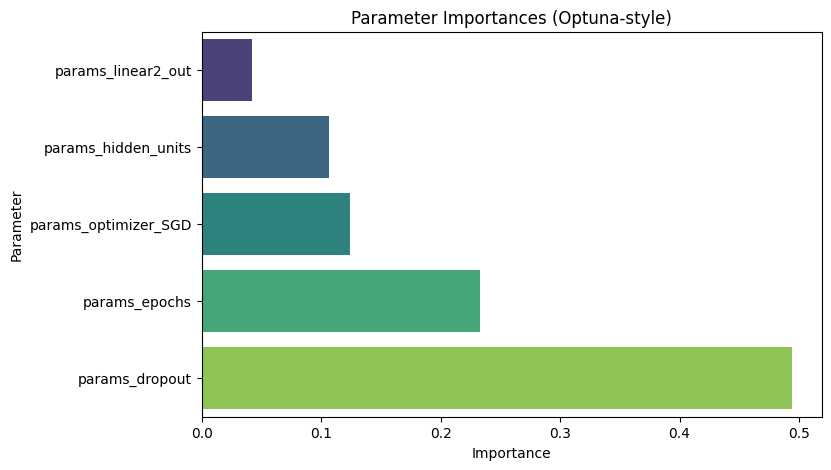

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


param_cols = [col for col in df.columns if col.startswith('params_')]

X = df[param_cols]
y = df["value"]


model = RandomForestRegressor(random_state=42)
model.fit(X, y)


importances = pd.Series(model.feature_importances_, index=param_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Parameter Importances (Optuna-style)")
plt.xlabel("Importance")
plt.ylabel("Parameter")
plt.show()
